In [1]:
import os

import numpy as np
import itertools
from itertools import cycle
import pandas as pd

import umap

import matplotlib.pyplot as plt
from matplotlib import offsetbox

import sklearn
from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, Conv1D, Deconvolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.text import *
from keras.utils import np_utils
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

from time import time
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from collections import Counter

/home/josh/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
# df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)

df = df[df['Country']!='VB']

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))
country_counts = df.groupby('Country').size()
print('{}'.format(country_counts))

X = df.iloc[:,6:-1]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]
y_country = df["Country"]
y_age_groups = df["AgeGroup"]
y_rearcnd = df["RearCnd"]


print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))
print('shape of y country : {}'.format(y_country.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y rearcnd : {}'.format(y_rearcnd.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)
y_country = np.asarray(y_country)
y_age_groups = np.asarray(y_age_groups)
y_rearcnd = np.asarray(y_rearcnd)

Species
AA    17251
AC     5995
AG    17481
dtype: int64
Status
BF     8611
GR     6737
SF    22102
UN     3277
dtype: int64
RearCnd
TF     9618
TL    27824
VF     3285
dtype: int64
Age
1     1596
2     1150
3     1530
4     2019
5     2323
6     2379
7     2630
8     2560
9     2796
10    2673
11    2704
12    2584
13    2816
14    2695
15    2869
16    2664
17    2739
dtype: int64
Country
B     8677
S     6430
T    25620
dtype: int64
shape of X : (40727, 1625)
shape of y age : (40727,)
shape of y species : (40727,)
shape of y status : (40727,)
shape of y country : (40727,)
shape of y age groups : (40727,)
shape of y rearcnd : (40727,)


In [12]:
y_country_rearcnd = [f'{country}-{rearcnd}' for country, rearcnd in zip(y_country, y_rearcnd)]
# print('shape of y country_rearcnd : {}'.format(y_country_rearcnd.shape))
y_country_rearcnd = np.asarray(y_country_rearcnd)
print('shape of y country_rearcnd : {}'.format(y_country_rearcnd.shape))

shape of y country_rearcnd : (40727,)


In [35]:
# Scale and visualize the embedding vectors
def plot_embedding_Age(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        indicies = np.where(Species==uniqueSpecies[i])[0]
        plt.scatter(X[indicies, 0], X[indicies, 1], c=y[indicies], cmap=colorMap, s=5)         
        plt.xticks([]), plt.yticks([])
        plt.title(uniqueSpecies[i])
    plt.colorbar()    
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

# Scale and visualize the embedding vectors
def plot_embedding_Malaria(X, y, saveDir=None, title=None):
    ## Sort tStandardScaler().fit_transform(X=he data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
      
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(1,1,1)
    indicies = np.where(y==0)[0]
    Malaria_label = 'No Malaria'
    plt.scatter(X[indicies, 0], X[indicies, 1], color = 'b', label=Malaria_label)         
    indicies = np.where(y==1)[0]
    Malaria_label = 'Malaria'
    plt.scatter(X[indicies, 0], X[indicies, 1], color = 'r', label=Malaria_label)         
    plt.xticks([]), plt.yticks([])
    plt.legend()  
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

# Scale and visualize the embedding vectors
def plot_embedding_Species(X, y, Species=None, saveDir=None, title=None):
    color_choice = ['bo', 'ro']
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    colors = ['b', 'r', 'g']
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(1,1,1)
    for i in range(len(uniqueSpecies)):
        indicies = np.where(Species==uniqueSpecies[i])[0]
        Species_label = Species[indicies[0]]
        plt.scatter(X[indicies, 0], X[indicies, 1], color = colors[i], label=Species_label)         
         
    plt.xticks([]), plt.yticks([])
    plt.legend()
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_country(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'k']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'S':
                    y_label.append('Glasgow')
                elif lab == 'T':
                    y_label.append('Ifakara')
                elif lab == 'B':
                    y_label.append('Bobo')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=18)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=18)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=18)
#     fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.18), fontsize=18)
    fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)
    
#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_rearCnd(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'TF':
                    y_label.append('Time Course Field')
                elif lab == 'TL':
                    y_label.append('Time Course Lab')
                elif lab == 'VF':
                    y_label.append('Validation Field')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    print(f'y_color shape : {y_color.shape}')
    print(f'y_label shape : {y_label.shape}')
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=18)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=18)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=18)
#         plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)

#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_rearCnd_Country(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'tab:brown', 'tab:orange', 'tab:purple']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'S-TF':
                    y_label.append('Glasgow - Time Course Field')
                elif lab == 'T-TF':
                    y_label.append('Ifakara - Time Course Field')
                elif lab == 'B-TF':
                    y_label.append('Bobo - Time Course Field')
                elif lab == 'S-TL':
                    y_label.append('Glasgow - Time Course Lab')
                elif lab == 'T-TL':
                    y_label.append('Ifakara - Time Course Lab')
                elif lab == 'B-TL':
                    y_label.append('Bobo - Time Course Lab')
                elif lab == 'S-VF':
                    y_label.append('Glasgow - Validation Field')
                elif lab == 'T-VF':
                    y_label.append('Ifakara - Validation Field')
                elif lab == 'B-VF':
                    y_label.append('Bobo - Validation Field')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    print(f'y_color shape : {y_color.shape}')
    print(f'y_label shape : {y_label.shape}')
    print(f'unique y shape : {unique_y.shape}')
    
    fig = plt.figure(figsize=(20,10))
    S = []
    L = []
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
#         S = []
#         L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                if not list(y_label[indicies]):
                    pass
                else:
                    if list(y_label[indicies])[0] not in L:
                        L.append(list(y_label[indicies])[0])
                        S.append(S1)
#             if not list(y_label[indicies]):
#                 pass
#             else:
#                 L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis', fontsize=18)
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii', fontsize=18)
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae', fontsize=18)
#         plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    print(L)
    fig.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.01), fontsize=18, markerscale=4.)

#     if title is not None:
#         fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_status(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'BF':
                    y_label.append('Blood Fed')
                elif lab == 'GR':
                    y_label.append('Gravid')
                elif lab == 'SF':
                    y_label.append('Sugar Fed')
            lab_val += 1
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
def plot_embedding_country_species(X, y, Species, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

#     if Species is not None:
    uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', ]
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        for j in Species:
            lab_val = 0
            for lab1 in unique_y:
                for lab2 in uniqueSpecies:
                    if i == lab1 and j == lab2:
                        y_color.append(colors[lab_val])
                        if lab1 == 'S' and lab2 == 'AA':
                            y_label.append('An. Arabiensis - Glasgow')
                        elif lab1 == 'T' and lab2 == 'AA':
                            y_label.append('An. Arabiensis - Ifakara')
                        elif lab1 == 'B' and lab2 == 'AA':
                            y_label.append('An. Arabiensis - Bobo')
                        elif lab1 == 'S' and lab2 == 'AC':
                            y_label.append('An. Coluzzii - Glasgow')
                        elif lab1 == 'T' and lab2 == 'AC':
                            y_label.append('An. Coluzzii - Ifakara')
                        elif lab1 == 'B' and lab2 == 'AC':
                            y_label.append('An. Coluzzii - Bobo')
                        elif lab1 == 'S' and lab2 == 'AG':
                            y_label.append('An. Gambiae - Glasgow')
                        elif lab1 == 'T' and lab2 == 'AG':
                            y_label.append('An. Gambiae - Ifakara')
                        elif lab1 == 'B' and lab2 == 'AG':
                            y_label.append('An. Gambiae - Bobo')
                    lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    ax = plt.subplot(1,1,1)
    for i in range(len(uniqueSpecies)):
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        plt.legend((S), (L), loc='center right', bbox_to_anchor=(1.1, 0.5))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

In [ ]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/UMAP/outputs/MIMI_data/'

## Scale features
features = X
X_scaled = StandardScaler().fit_transform(X=features)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
plot_embedding_Age(transformed, y_age, y_species, saveDir, ('UMAP Embedded Mosquito Age'))


In [5]:
saveDir = 'outputs/MIMI_data/'

## Scale features
features = X
X_scaled = StandardScaler().fit_transform(X=features)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
# print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
# plot_embedding_country(transformed, y_country, y_species, saveDir, ('UMAP_Embedded_Mosquito_Country'), colorMap='Set1')


Computing UMAP projection
Embedding time: 976.7143931388855


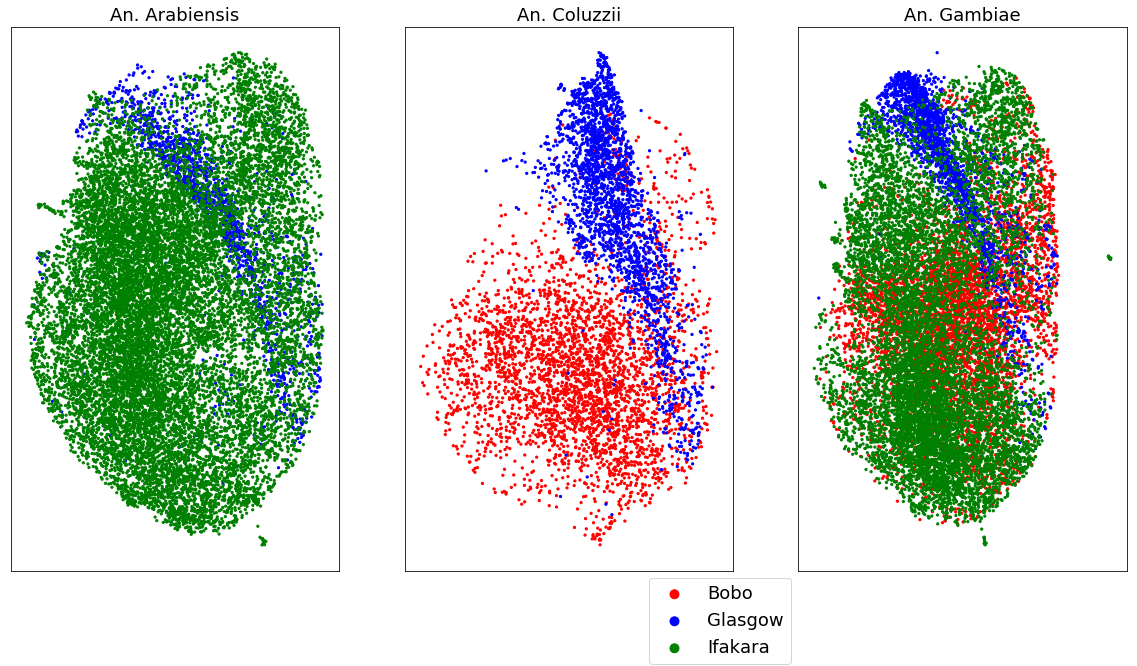

In [42]:
plot_embedding_country(transformed, y_country, y_species, saveDir, ('UMAP_Embedded_Mosquito_Country'), colorMap='Set1')


y_color shape : (40727,)
y_label shape : (40727,)


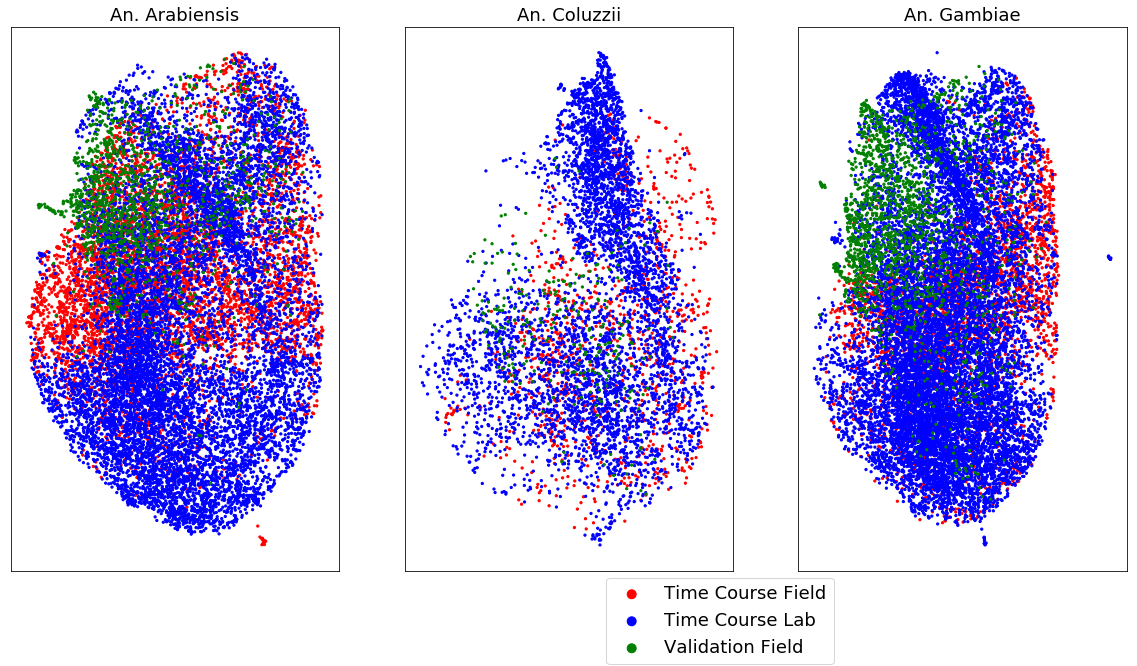

In [17]:
## Call plotting function
plot_embedding_rearCnd(transformed, y_rearcnd, y_species, saveDir, ('UMAP_Embedded_Mosquito_RearCnd'), colorMap='Set1')


y_color shape : (40727,)
y_label shape : (40727,)
unique y shape : (7,)
['Glasgow - Time Course Lab', 'Ifakara - Time Course Field', 'Ifakara - Time Course Lab', 'Ifakara - Validation Field', 'Bobo - Time Course Field', 'Bobo - Time Course Lab', 'Bobo - Validation Field']


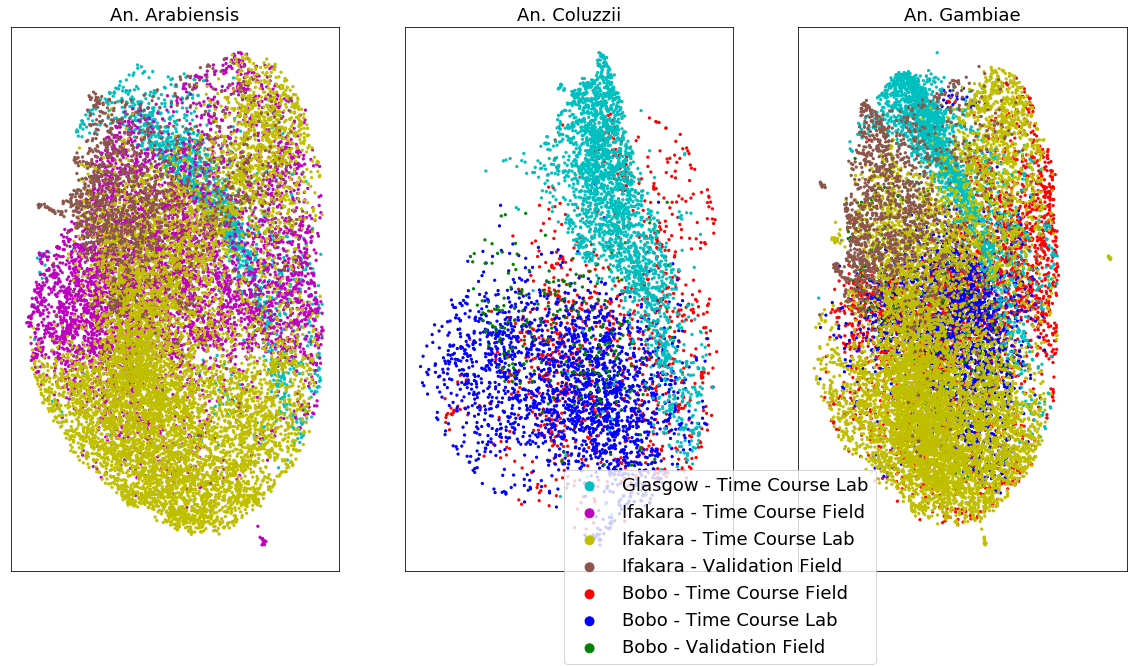

In [36]:
## Call plotting function
plot_embedding_rearCnd_Country(transformed, y_country_rearcnd, y_species, saveDir, ('UMAP_Embedded_Mosquito_RearCnd_Country'), colorMap='Set1')


In [ ]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/UMAP/outputs/MIMI_data/'

## Scale features
features = X
X_scaled = StandardScaler().fit_transform(X=features)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
# print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
plot_embedding_status(transformed, y_status, y_species, saveDir, ('UMAP Embedded Mosquito Status'), colorMap='Set1')


In [ ]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/UMAP/outputs/MIMI_data/'

## Scale features
features = X
X_scaled = StandardScaler().fit_transform(X=features)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
# print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
plot_embedding_country_species(transformed, y_country, y_species, saveDir, ('UMAP Embedded Mosquito Country and Species'), colorMap='Set1')


In [ ]:
plot_embedding_country_species(transformed, y_country, y_species, saveDir, ('UMAP Embedded Mosquito Country and Species'), colorMap='Set1')


In [3]:
df_all = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df_all.head(10)

# df_all = df_all[df_all['Country']!='S']

Species_counts_all = df_all.groupby('Species').size()
print('{}'.format(Species_counts_all))
Status_counts_all = df_all.groupby('Status').size()
print('{}'.format(Status_counts_all))
RearCnd_counts_all = df_all.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts_all))
age_counts_all = df_all.groupby('Age').size()
print('{}'.format(age_counts_all))
country_counts_all = df_all.groupby('Country').size()
print('{}'.format(country_counts_all))

X_all = df_all.iloc[:,6:]
y_age_all = df_all["Age"]
y_species_all = df_all["Species"]
y_status_all = df_all["Status"]
y_country_all = df_all["Country"]
y_rearcnd_all = df_all["RearCnd"]

print('shape of X : {}'.format(X_all.shape))
print('shape of y age : {}'.format(y_age_all.shape))
print('shape of y species : {}'.format(y_species_all.shape))
print('shape of y status : {}'.format(y_status_all.shape))
print('shape of y country : {}'.format(y_country_all.shape))
print('shape of y rearcnd : {}'.format(y_rearcnd_all.shape))

X_all = np.asarray(X_all)
y_age_all = np.asarray(y_age_all)
y_species_all = np.asarray(y_species_all)
y_status_all = np.asarray(y_status_all)
y_country_all = np.asarray(y_country_all)
y_rearcnd_all = np.asarray(y_rearcnd_all)

Species
AA    16170
AC     4642
AG    13849
dtype: int64
Status
BF     6367
GR     6188
SF    22106
dtype: int64
RearCnd
TF     6495
TL    25481
VF     2685
dtype: int64
Age
1     1182
2      812
3     1035
4     1541
5     1903
6     1862
7     2312
8     2254
9     2415
10    2377
11    2464
12    2268
13    2569
14    2331
15    2515
16    2304
17    2517
dtype: int64
Country
B     6035
S     5667
T    22959
dtype: int64
shape of X : (34661, 1625)
shape of y age : (34661,)
shape of y species : (34661,)
shape of y status : (34661,)
shape of y country : (34661,)
shape of y rearcnd : (34661,)


In [37]:
def plot_embedding_rearCnd(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = []
    y_label = []
    unique_y = np.unique(y)
    for i in y:
        lab_val = 0
        for lab in unique_y:
            if i == lab:
                y_color.append(colors[lab_val])
                if lab == 'TF':
                    y_label.append('Time Course Field')
                elif lab == 'TL':
                    y_label.append('Time Course Lab')
                elif lab == 'VF':
                    y_label.append('Validation Field')
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")
    
    
def plot_embedding_rearCnd_Age(X, y, Species=None, Age=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
        
    if Age is not None:
        uniqueAges = np.unique(Age)
    
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = np.zeros((len(y), 4))
    y_label = []
    unique_y = np.unique(y)
#     Age = Age/18
    Age_groups = np.where((Age>=1) & (Age<=4) & (y=='TF'), 1, 0)
    Age_groups = np.where((Age>=1) & (Age<=4) & (y=='TL'), 2, 0)
    Age_groups = np.where((Age>=1) & (Age<=4) & (y=='VF'), 3, 0)
    Age_groups = np.where((Age>=5) & (Age<=10) & (y=='TF'), 4, Age_groups)
    Age_groups = np.where((Age>=5) & (Age<=10) & (y=='TL'), 5, Age_groups)
    Age_groups = np.where((Age>=5) & (Age<=10) & (y=='VF'), 6, Age_groups)
    Age_groups = np.where((Age>=11) & (y=='TF'), 7, Age_groups)
    Age_groups = np.where((Age>=11) & (y=='TL'), 8, Age_groups)
    Age_groups = np.where((Age>=11) & (y=='VF'), 9, Age_groups)
#     Age_groups = np.where((Age>=5) & (Age<=10), 4, Age_groups)
#     Age_groups = np.where((Age>=11), 5, Age_groups)
#     Age_groups = Age_groups/4
    
    fig = plt.figure()
    plt.scatter(0, 0, c=np.array([1,0.5,0,1]))
    plt.scatter(1, 0, c=np.array([1,0,0.5,1]))
    plt.scatter(2, 0, c=np.array([1,0,0,1]))
    plt.scatter(3, 0, c=np.array([0.5,1,0,1]))
    plt.scatter(4, 0, c=np.array([0,1,0.5,1]))
    plt.scatter(5, 0, c=np.array([0,1,0,1]))
    plt.scatter(6, 0, c=np.array([0.5,0,1,1]))
    plt.scatter(7, 0, c=np.array([0,0.5,1,1]))
    plt.scatter(8, 0, c=np.array([0,0,1,1]))
    
    for i, age, count in zip(y, Age_groups, range(len(y))):
#         lab_val = 0
#         for lab in unique_y:
#             if i == lab:
#                 y_color.append(colors[lab_val])
        if age==1:
            y_color[count,0] = 1.0
            y_color[count,3] = 0.7
            y_label.append('Time Course Field')
        if age==2:
            y_color[count,0] = 1.0
            y_color[count,1] = 0.8
            y_color[count,3] = 0.7
            y_label.append('Time Course Lab')
        if age==3:
            y_color[count,0] = 1.0
            y_color[count,2] = 0.8
            y_color[count,3] = 0.7
            y_label.append('Validation Field')
        if age==4:
            y_color[count,1] = 1.0
            y_color[count,3] = 0.7
            y_label.append('Time Course Field')
        if age==5:
            y_color[count,1] = 1.0
            y_color[count,0] = 0.8
            y_color[count,3] = 0.7
            y_label.append('Time Course Lab')
        if age==6:
            y_color[count,1] = 1.0
            y_color[count,2] = 0.8
            y_color[count,3] = 0.7
            y_label.append('Validation Field')
        if age==7:
            y_color[count,2] = 1.0
            y_color[count,3] = 0.7
            y_label.append('Time Course Field')
        if age==8:
            y_color[count,2] = 1.0
            y_color[count,1] = 0.8
            y_color[count,3] = 0.7
            y_label.append('Time Course Lab')
        if age==9:
            y_color[count,2] = 1.0
            y_color[count,0] = 0.8
            y_color[count,3] = 0.7
            y_label.append('Validation Field')
#                 if age==4:
#                     y_color[count,lab_val] = 1.0
#                     y_color[count,lab_val-1] = 0.8
#                     y_color[count,3] = 0.7
#                 if age==5:
#                     y_color[count,lab_val] = 1.0
#                     y_color[count,lab_val+1] = 0.8
#                     y_color[count,3] = 0.7
#                 if lab == 'TF':
#                     y_label.append('Time Course Field')
#                 elif lab == 'TL':
#                     y_label.append('Time Course Lab')
#                 elif lab == 'VF':
#                     y_label.append('Validation Field')
#                     y_color[count,3] = 0
#             lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
    print(y_color)
    
#     print(y_color.shape)
    print(X.shape)
    print(y.shape)
    print(y_color.shape)
    print(y_label.shape)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=3)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[-1])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

Computing UMAP projection
Embedding time: 249.218656539917
[[0.         0.05555556 0.         0.7       ]
 [0.         0.05555556 0.         0.7       ]
 [0.         0.05555556 0.         0.7       ]
 ...
 [0.         0.         0.94444444 0.        ]
 [0.         0.         0.94444444 0.        ]
 [0.         0.         0.94444444 0.        ]]


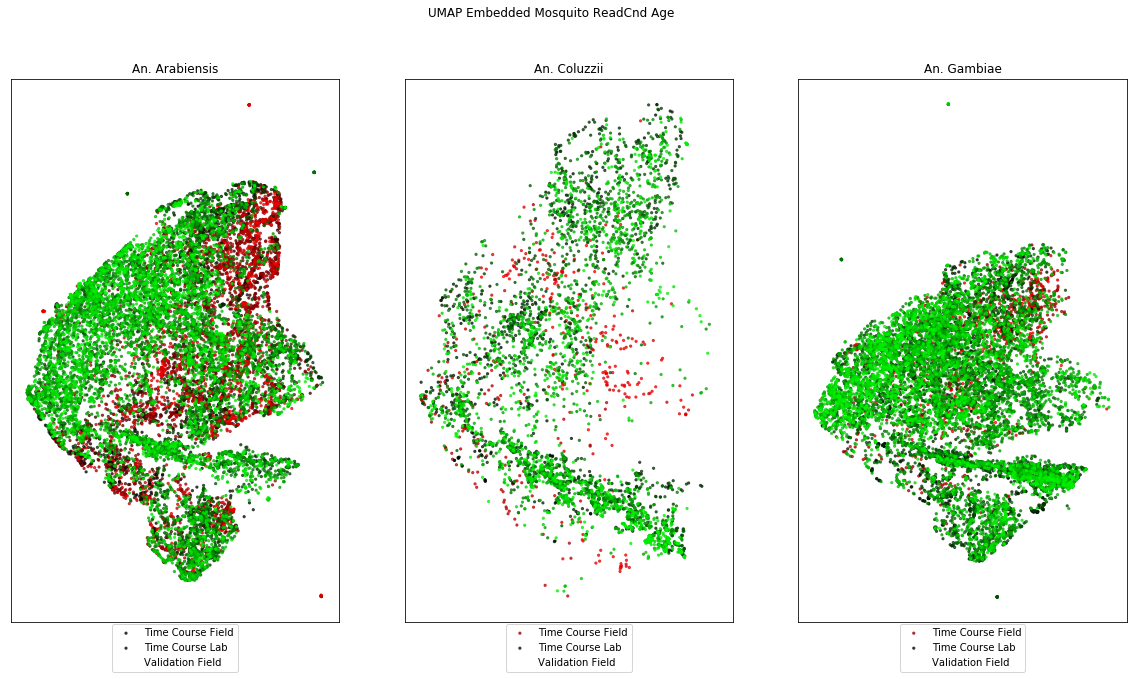

In [5]:
saveDir = '/home/josh/Documents/Mosquito_Project/New_Data/Models/Dimension_Reduction/UMAP/outputs/MIMI_data/'

## Scale features
features = X_all
X_scaled = StandardScaler().fit_transform(X=features)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 8
num_min_dist = 0.2#0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
# print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
reducer = umap.UMAP(random_state=42, n_components=dimensions)
# reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
plot_embedding_rearCnd_Age(transformed, y_rearcnd_all, y_species_all, y_age_all, saveDir, ('UMAP Embedded Mosquito ReadCnd Age'), colorMap='Set1')


In [ ]:
plot_embedding_rearCnd_Age(transformed, y_rearcnd_all, y_species_all, y_age_all, saveDir, ('UMAP Embedded Mosquito ReadCnd Age'), colorMap='Set1')


[[0.         0.05555556 0.         0.7       ]
 [0.         0.05555556 0.         0.7       ]
 [0.         0.05555556 0.         0.7       ]
 ...
 [0.         0.         0.94444444 0.        ]
 [0.         0.         0.94444444 0.        ]
 [0.         0.         0.94444444 0.        ]]


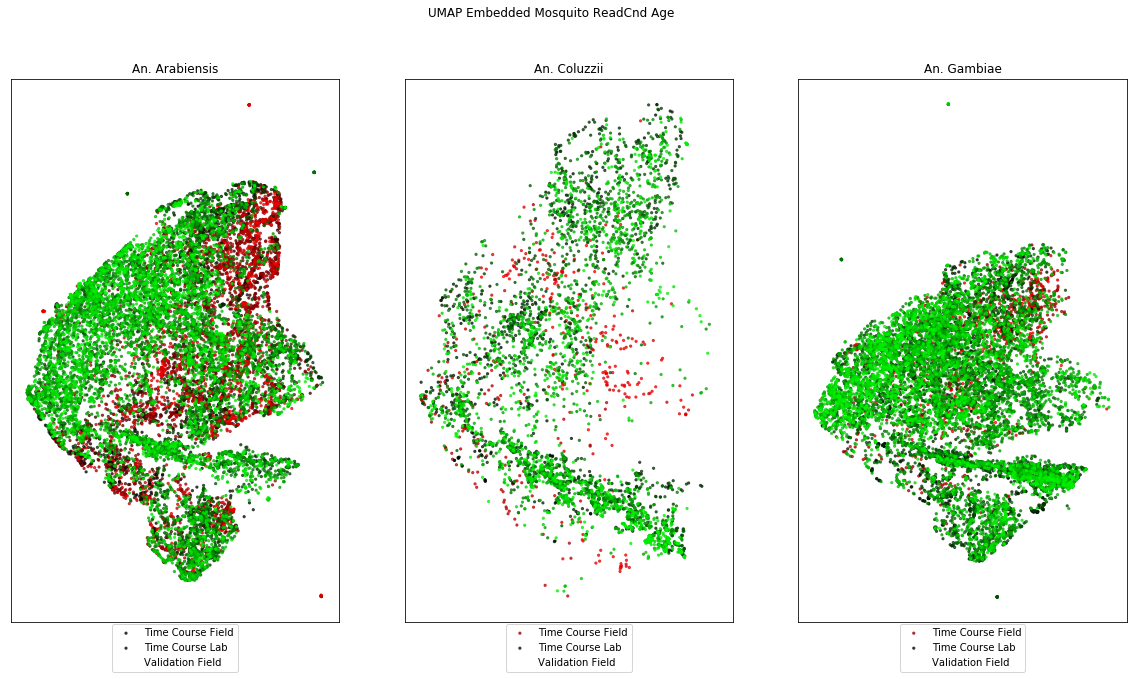

In [38]:
plot_embedding_rearCnd_Age(transformed, y_rearcnd_all, y_species_all, y_age_all, saveDir, ('UMAP Embedded Mosquito ReadCnd Age'), colorMap='Set1')


In [64]:
## for visualizing losses and metrics once the neural network fold is trained
def visualize(histories, save_path, model_name, fold, classes, outputs, predicted, true, titles):
    # Sort out predictions and true labels
    for label_predictions_arr, label_true_arr, classes, outputs, title in zip(predicted, true, classes, outputs, titles):
        label_predictions_arr = label_predictions_arr[0]
        label_true_arr = label_true_arr[0]
        classes_pred = np.argmax(label_predictions_arr, axis=-1)
        classes_true = np.argmax(label_true_arr, axis=-1)
#         print(label_predictions_arr.shape)
#         print(label_true_arr.shape)
        print(classes_pred)
        print(classes_true)
#         accuracies = np.zeros((17))
#         totals = np.zeros((17))
#         for index in range(0,len(classes_true)):
#             totals[classes_true[index]] += 1
#             if classes_true[index] == classes_pred[index]:
#                 accuracies[classes_true[index]] += 1
#             if classes_true[index] == classes_pred[index]-1:
#                 accuracies[classes_true[index]] += 1
#         print('Classification accuracies')
#         print('1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17')
#         print('{}'.format(accuracies/totals))
        
        cnf_matrix = confusion_matrix(classes_true, classes_pred)
        
#         for age in range(1,18):
            
#         print(cnf_matrix)
#         classes = np.unique(np.hstack((classes_pred, classes_true)))
#         print(outputs)
#         if outputs=='xAge':
#             classes = [c+1 for c in classes]
#         print(classes)
        plot_confusion_matrix(cnf_matrix, classes, outputs, save_path, model_name, fold, title)

In [65]:
def plot_confusion_matrix(cm, classes, output, save_path, model_name, fold, title,
                          normalize=True,
                          cmap=plt.cm.Blues,
                          printout=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printout:
            print("Normalized confusion matrix")
    else:
        if printout:
            print('Confusion matrix, without normalization')

    if printout:
        print(cm)
    
    plt.figure(figsize=(8,8))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=np.max(np.sum(cm, axis=1)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title([title+' - '+model_name])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout(pad=1.2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((save_path+"Confusion_Matrix_"+model_name+"_"+fold+"_"+output[1:]+".png"))
    plt.close()

In [100]:
## Plotting with alpha on miss-classification

def plot_embedding_rearCnd_Acc(X, y, Species=None, Accuracy=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    colors = ['r', 'b', 'g', 'o', 'p']
    y_color = np.zeros((len(y), 4))
    y_label = []
    unique_y = np.unique(y)
#     print(unique_y)
    for i, acc, count in zip(y, Accuracy, range(len(y))):
        lab_val = 0
        for lab in unique_y:
            if i == lab:
#                 y_color.append(colors[lab_val])
                y_color[count,lab_val] = 1.0
                y_color[count,3] = 0.0
                if acc == 0:
                    y_color[count,0] = 0.0
                    y_color[count,1] = 0.0
                    y_color[count,2] = 0.0
                    y_color[count,3] = 0.0
                if lab == 'TF':
                    y_label.append('Time Course Field')
                elif lab == 'TL':
                    y_label.append('Time Course Lab')
                elif lab == 'VF':
                    y_label.append('Validation Field')
                    y_color[count,3] = 0
            lab_val += 1
    y_color = np.asarray(y_color)
    y_label = np.asarray(y_label)
#     print(y_color)
    
#     print(y_color.shape)
    
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        S = []
        L = []
        for j in range(len(unique_y)):
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], y==unique_y[j]))[0]
#             print(indicies)
    #         L = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], cmap=colorMap, s=5) 
            if not list(indicies):
                pass
            else:
                S1 = plt.scatter(X[indicies, 0], X[indicies, 1], c=y_color[indicies], label=y_label[indicies], s=5)       
                S.append(S1)
            if not list(y_label[indicies]):
                pass
            else:
                L.append(list(y_label[indicies])[0])

        plt.xticks([]), plt.yticks([])
        if uniqueSpecies[i] =='AA':
            plt.title('An. Arabiensis')
        elif uniqueSpecies[i] =='AC':
            plt.title('An. Coluzzii')
        elif uniqueSpecies[i] =='AG':
            plt.title('An. Gambiae')
        plt.legend((S), (L), loc='lower center', bbox_to_anchor=(0.5, -0.1))
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")